In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import os
import sys

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data

from datasets.em_stack import EMStackDataset, load_dataset
from models.unet import UNet
from utils import display_predictions, display_segmentation

from tqdm import tqdm_notebook

In [4]:
data_directory = "/share/nikola/export/dt372/isbi"
train_volume, train_labels, test_volume = load_dataset(data_directory)

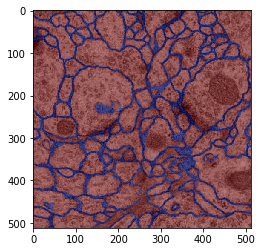

In [5]:
display_segmentation(train_volume[..., 0], train_labels[..., 0])

In [6]:
tr_ds, te_ds = EMStackDataset(train_volume, train_labels), \
               EMStackDataset(test_volume, test_volume, is_train=False)

In [7]:
tr_dl, te_dl = data.DataLoader(tr_ds), data.DataLoader(te_ds)

In [8]:
def set_lr(optimizer, model, cycle_length=10):
    if model.epoch % cycle_length == 0:
        new_lr = (1e-2) * (0.97 ** (model.epoch // 10))
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lr
        print("Learning rate changed to: %.5f" % new_lr)
def train(model, dataloader, criterion, optimizer, epochs,
          verbose=False, cycle_length=10):
    model.train()
    losses = []
    epoch_iter = trange(epochs, position=0) if verbose else range(epochs)
    for epoch in epoch_iter:
        set_lr(optimizer, model, cycle_length=cycle_length)
        tr_loss, total = 0., 0.
        dl_iter = tqdm_notebook(dataloader, position=1,
                       leave=False) if verbose else dataloader
        for x, y in tqdm_notebook(dataloader, position=1, leave=False):
            optimizer.zero_grad()
            if torch.cuda.is_available():
                x, y = x.cuda(), y.squeeze(dim=1).cuda()
            pred = model(x)
            loss = criterion(pred, y)
            tr_loss += loss.data.cpu()
            total += len(y)
            loss.backward()
            optimizer.step()
        overall_loss = tr_loss / len(dataloader)
        losses.append(overall_loss)
        if verbose:
            print(overall_loss)
        model.epoch += 1
    return losses

In [9]:
transposed_model = UNet(3, 1, 2, dilated=False)
if torch.cuda.is_available():
    transposed_model = transposed_model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transposed_model.parameters(), lr=1e-2, betas=(0.99, 0.999))
transposed_losses = []

Learning rate changed to: 0.01000


/home/dt372/anaconda2/envs/unet/lib/python3.7/site-packages/torchvision/transforms/functional.py:440: UserWarning: torch.gels is deprecated in favour of torch.lstsq and will be removed in the next release. Please use torch.lstsq instead.
  res = torch.gels(B, A)[0]


Learning rate changed to: 0.01000


Learning rate changed to: 0.01000


Learning rate changed to: 0.00970


Learning rate changed to: 0.00970


Learning rate changed to: 0.00941


Learning rate changed to: 0.00941


Learning rate changed to: 0.00941


Learning rate changed to: 0.00913


Learning rate changed to: 0.00913


Learning rate changed to: 0.00885


Learning rate changed to: 0.00885


Learning rate changed to: 0.00885


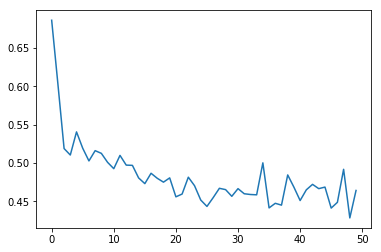

In [10]:
transposed_losses.extend(train(transposed_model, tr_dl, criterion, optimizer, 50, cycle_length=4))
plt.plot(list(range(transposed_model.epoch)), transposed_losses)

In [11]:
dilation_model = UNet(3, 1, 2)
if torch.cuda.is_available():
    dilation_model = dilation_model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dilation_model.parameters(), lr=1e-2, betas=(0.99, 0.999))
dilated_losses = []

Learning rate changed to: 0.01000


Learning rate changed to: 0.01000


Learning rate changed to: 0.01000


Learning rate changed to: 0.00970


Learning rate changed to: 0.00970


Learning rate changed to: 0.00941


Learning rate changed to: 0.00941


Learning rate changed to: 0.00941


Learning rate changed to: 0.00913


Learning rate changed to: 0.00913


Learning rate changed to: 0.00885


Learning rate changed to: 0.00885


Learning rate changed to: 0.00885


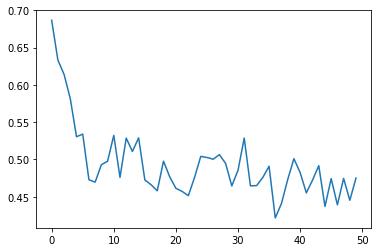

In [12]:
dilated_losses.extend(train(dilation_model, tr_dl, criterion, optimizer, 50, cycle_length=4))
plt.plot(list(range(dilation_model.epoch)), dilated_losses)

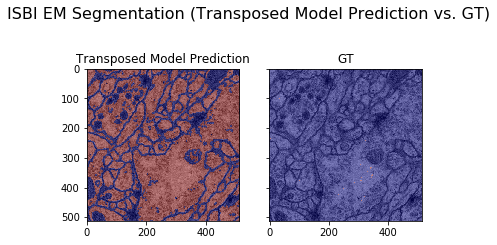

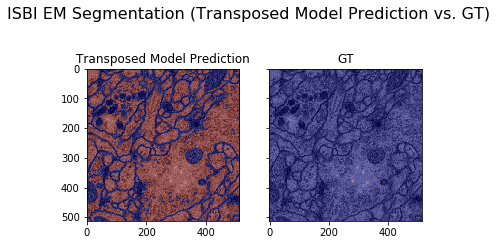

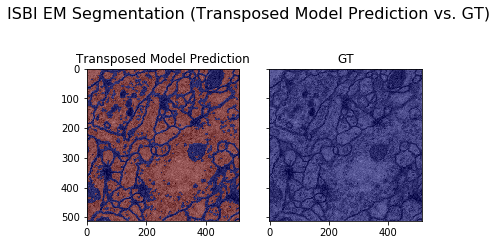

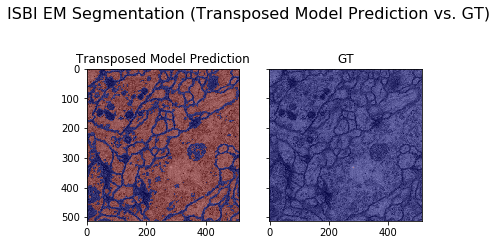

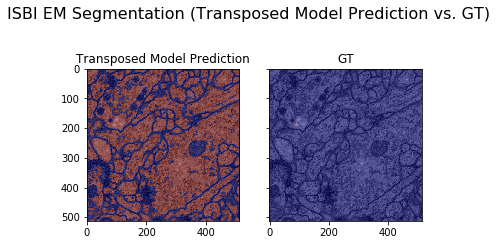

In [13]:
display_predictions(transposed_model, te_dl, model_name="Transposed Model")

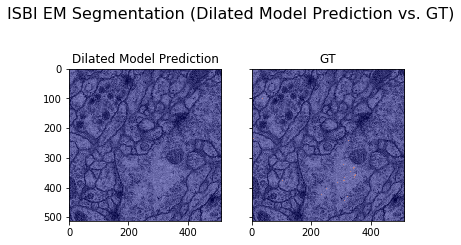

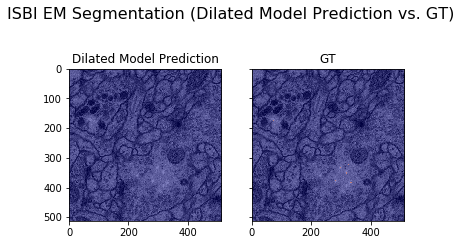

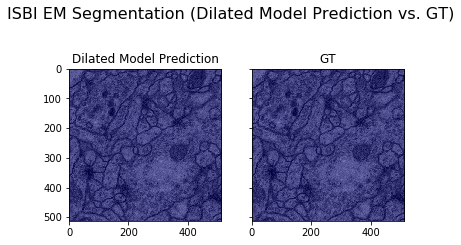

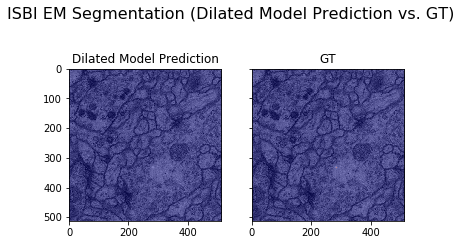

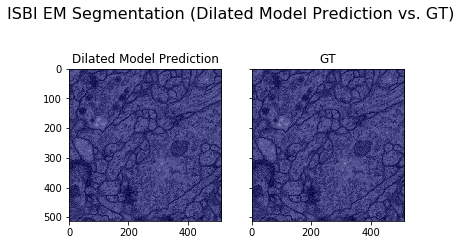

In [14]:
display_predictions(dilation_model, te_dl, model_name="Dilated Model")